https://www.kaggle.com/charel/learn-by-example-expectation-maximization/notebook
## Basic example of Expectation Maximization

Let's try this on a simple basic example.

Objective: Let's etimate the probability distribution in a 1-dimensional dataset

* that we generated ourselves using 2 gaussian normal probability distributions.
* Using a Gaussian mixture model with 2 normal gaussian distributions

Or in other words, we should be able to find our own mean and standard deviation parameters we used to generate the testset.

## Gaussian Mixture Model of Gaussians
J Normal distributions  $N(\mu_1,\sigma_1^2),\cdots,N(\mu_J,\sigma_J^2)$

Paramaters to estimate : $\Theta=(w_1,\cdots,w_{J-1},\mu_1,\cdots,\mu_J,\sigma_1^2,\cdots,\sigma_J^2)$

The probability density function (PDF) of the mixture model is:

$$f(x|\Theta)=\sum_{j=1}^Jw_jf(x|\mu_j,\sigma_j^2),~~\sum_jw_j=1$$
 
Objective is to best fit a given probability density by finding $\hat{\Theta}$ through EM iterations.

Let's try the case $J=3$.

In [17]:
# import libraries

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

#for matrix math
import numpy as np

#for normalization + probability density function computation
from scipy import stats

#for data preprocessing
import pandas as pd
from math import sqrt, log, exp, pi
from random import uniform
print("import done")

import done


## Generate the dataset

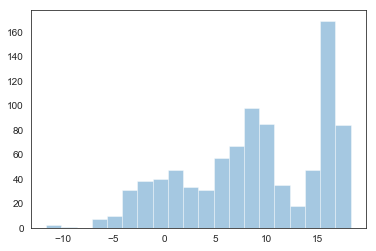

In [18]:
mean1 = 1 ; sd1 = 4
mean2 = 9 ; sd2 = 2
mean3 = 16 ; sd3 = 1

# generate data
y1 = np.random.normal(mean1, sd1, 300)
y2 = np.random.normal(mean2, sd2, 300)
y3 = np.random.normal(mean3, sd3, 300)
data=np.append(y1,y2)
data=np.append(data,y3)

# For data visiualisation calculate left and right of the graph
Min_graph = min(data)
Max_graph = max(data)
x = np.linspace(Min_graph, Max_graph, 2000) # for later use to plot the data

sns.distplot(data, bins=20, kde=False)

In [19]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

## A single Gaussian model may fail

Best single Gaussian: μ = 8.7, σ = 6.6


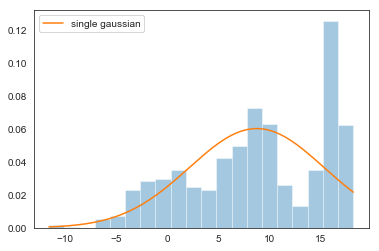

In [20]:
#gaussian of best fit
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))

#fit a single gaussian curve to the data
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian')
plt.legend();

## Gaussian Mixture for EM

In [26]:
class GaussianMixture_self:
    "Model mixture of J univariate Gaussians and their EM estimation"

    def __init__(self, data, J, mu_min=min(data), mu_max=max(data), sigma_min=1, sigma_max=1) :
        self.data = data
#         todo the Algorithm would be numerical enhanced by normalizing the data first, next do all 
#         the EM steps and do the de-normalising at the end
        
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = 1/J

    def Estep(self):
        "Perform an E(stimation)-step, assign each point to gaussians with a percentage" # -----------------------
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:  
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den   
            wp2 /= den     # wp1+wp2= 1, it either belongs to gaussian 1 or gaussion 2
            # add into loglike
            self.loglike += log(wp1 + wp2) #freshening up self.loglike in the process
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights) 
        one_den = sum(left)
        two_den = sum(rigt)

        # compute new means
        self.one.mu = sum(w * d  for (w, d) in zip(left, data)) / one_den
        self.two.mu = sum(w * d  for (w, d) in zip(rigt, data)) / two_den
        
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

        
    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #The heart of the algorith, perform E-stepand next M-step
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)
print("done")

done
